## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch

import matplotlib.pyplot as plt
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

from src.models.normal_deg import NormalDegradationModel as NModel, NormalDegradationNLL as NLoss
from src.pipelines.init_states import PlotNormalDistWithData,BestModelTracker

In [2]:
data_name = "DS03"

device = "cpu" # cpu is faster for small models/datasets
experiment_dir = Path('experiments')/data_name
states_dir = experiment_dir/'states'
os.makedirs(states_dir, exist_ok=True)

## Import training data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')

### Select degraded data

In [4]:
hi_df = hi_df[hi_df['hs']==0]
del hi_df['hs']

In [5]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]
units = hi_df['unit'].unique().tolist()

performs_train = {alias: 
    {int(unit): hi_df[hi_df['unit']==unit][alias].values for unit in units} 
    for alias in perform_names
}
time_train = {int(unit): hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Model initialization

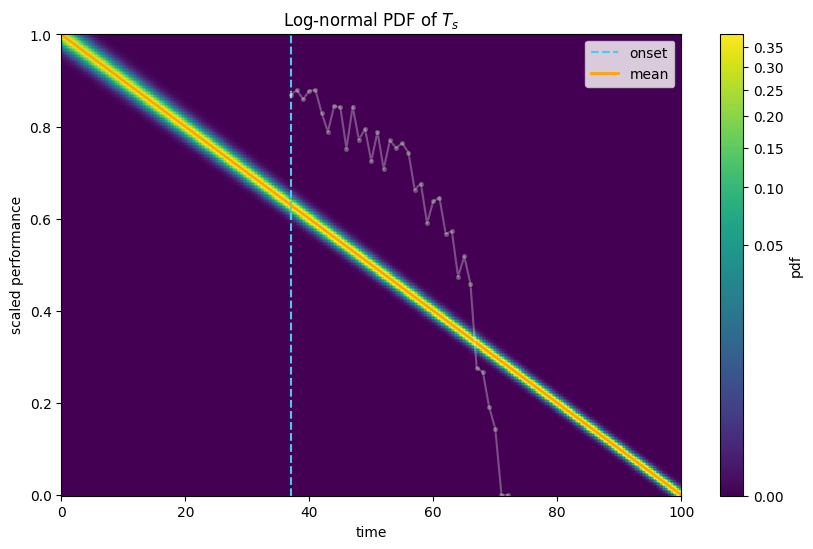

In [6]:
s_np:np.ndarray = performs_train['SmLPC'][1]
t_np:np.ndarray = time_train[1]
onset = float(t_np[0])

# grids
t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s = np.linspace(0.0, 1.0, 300)

model = NModel(onset=onset)

ax = model.plot_distribution(
    t=t,
    s=s,
    func="pdf",
    title="Log-normal PDF of $T_s$",
)

ax.plot(t_np,s_np,'o-',
		color='white',alpha=0.3,markersize=4,markeredgecolor='black',markeredgewidth=0.8,
  		label='data')
plt.show()

## Create Initial Particles (Training)
The number of (pure) particles $N$ is the the number of training trajectories.

## Callbacks

In [7]:
early_stop_cb = EarlyStopping(
	monitor="train_loss",
	patience=500,
	threshold=1e-5,
	threshold_mode="rel",
	lower_is_better=True,
)

besttracker_cb=BestModelTracker(
	monitor  = "train_loss",
	min_delta = 0.01,
	save_dir = ".", # to be set later
	f_params = "best_model.pt",
	load_best = True,  
)

plot_cb = PlotNormalDistWithData(
	t_grid=t,
	s_grid=s,
	time_data=None,   # to be set later           
	perform_data=None, # to be set later          
	plot_every=None,
	func="pdf",
	title=None,
	plot_at_end = True,
	show=False,
	save_dir= None,   # to be set later             
)
    

## Regressor

In [8]:
net = NeuralNetRegressor(
            module=NModel,
            module__onset=None,  # to be set later
            criterion=NLoss,
            optimizer=torch.optim.Adam,
            lr=1e-2,
            max_epochs=100_000,
            batch_size=-1,
            train_split=None,
            device=device,
            verbose=0,
            callbacks=[besttracker_cb,early_stop_cb, plot_cb],
        )

## Train

In [9]:
t = np.linspace(0.1, 100, 400) 
s = np.linspace(0.0, 1.0, 300)

for perform_name, units_perform in performs_train.items():
    print(f"\nTraining performance: {perform_name}")
    for unit, perform in units_perform.items():
        print(f"  Unit {unit}/{len(units_perform)}", end=" ", flush=True)

		# Prepare data for training 
        t_np: np.ndarray = time_train[unit]
        s_np: np.ndarray = perform

        X = s_np.astype(np.float32).reshape(-1, 1)
        y = t_np.astype(np.float32).reshape(-1, 1)
        
        # update callbacks with unit-specific info
        unit_dir = states_dir / perform_name / f"unit_{unit}"
        besttracker_cb.save_dir = unit_dir
        plot_cb.save_dir = unit_dir
        plot_cb.title = f"Normal SP for perform {perform_name} Unit {unit}"
        plot_cb.time_data = t_np
        plot_cb.perform_data = s_np
  
        net.set_params(module__onset=float(t_np[0]))
        net.initialize()
        net.fit(X, y)

        print("Done")

print("initial states training completed.")


Training performance: T48
  Unit 1/9 Done
  Unit 2/9 Done
  Unit 3/9 Done
  Unit 4/9 Done
  Unit 5/9 Done
  Unit 6/9 Done
  Unit 7/9 Done
  Unit 8/9 Done
  Unit 9/9 Done

Training performance: SmLPC
  Unit 1/9 Done
  Unit 2/9 Done
  Unit 3/9 Done
  Unit 4/9 Done
  Unit 5/9 Done
  Unit 6/9 Done
  Unit 7/9 Done
  Unit 8/9 Done
  Unit 9/9 Done

Training performance: SmHPC
  Unit 1/9 Done
  Unit 2/9 Done
  Unit 3/9 Done
  Unit 4/9 Done
  Unit 5/9 Done
  Unit 6/9 Done
  Unit 7/9 Done
  Unit 8/9 Done
  Unit 9/9 Done
initial states training completed.
